In [20]:
  import torch
  import torchvision.datasets as dsets
  import torchvision.transforms as transforms
  import matplotlib.pylab as plt

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1)
if device == 'cuda':
  torch.cuda.manual_seed_all(1)

In [3]:
# parameters
learning_rate = 0.01
training_epochs = 10
batch_size = 32

In [11]:
# MNIST dataset

mnist_train = dsets.MNIST(root = 'MNIST_data/',
                          train = True,
                          transform = transforms.ToTensor(),
                          download = True)
mnist_test = dsets.MNIST(root = 'MNIST_data',
                          train= False,
                          transform = transforms.ToTensor(),
                          download=True
                          )

In [12]:
# dataset loader
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=True)

In [6]:
# nn layers
linear1 = torch.nn.Linear(784,32, bias = True)
linear2 = torch.nn.Linear(32,32, bias = True)
linear3 = torch.nn.Linear(32,10, bias = True)
relu = torch.nn.ReLU()
bn1 = torch.nn.BatchNorm1d(32)
bn2 = torch.nn.BatchNorm1d(32)


nn_linear1 = torch.nn.Linear(784,32, bias = True)
nn_linear2 = torch.nn.Linear(32,32, bias = True)
nn_linear3 = torch.nn.Linear(32,10, bias = True)

In [7]:
# model
bn_model = torch.nn.Sequential(linear1, bn1,relu,linear2, bn2, relu, linear3).to(device)

nn_model = torch.nn.Sequential(nn_linear1, relu, nn_linear2, relu,nn_linear3).to(device)

In [8]:
# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)
bn_optimizer = torch.optim.Adam(bn_model.parameters(), lr = learning_rate)
nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr = learning_rate)

In [23]:
# Save Losses and Accuracies every epoch
# We are going to plot them later
train_losses = []
train_accs = []

valid_losses = []
valid_accs = []

train_total_batch = len(train_loader)
test_total_batch = len(test_loader)
for epoch in range(training_epochs):
    bn_model.train()  # set the model to train mode

    for X, Y in train_loader:
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        bn_optimizer.zero_grad()
        bn_prediction = bn_model(X)
        bn_loss = criterion(bn_prediction, Y)
        bn_loss.backward()
        bn_optimizer.step()

        nn_optimizer.zero_grad()
        nn_prediction = nn_model(X)
        nn_loss = criterion(nn_prediction, Y)
        nn_loss.backward()
        nn_optimizer.step()

    with torch.no_grad():
        bn_model.eval()     # set the model to evaluation mode

        # Test the model using train sets
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, Y) in enumerate(train_loader):
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / train_total_batch, nn_loss / train_total_batch, bn_acc / train_total_batch, nn_acc / train_total_batch

        # Save train losses/acc
        train_losses.append([bn_loss, nn_loss])
        train_accs.append([bn_acc, nn_acc])
        print(
            '[Epoch %d-TRAIN] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
            (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
        # Test the model using test sets
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, Y) in enumerate(test_loader):
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / test_total_batch, nn_loss / test_total_batch, bn_acc / test_total_batch, nn_acc / test_total_batch

        # Save valid losses/acc
        valid_losses.append([bn_loss, nn_loss])
        valid_accs.append([bn_acc, nn_acc])
        print(
            '[Epoch %d-VALID] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
                (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
        print()

print('Learning finished')

[Epoch 1-TRAIN] Batchnorm Loss(Acc): bn_loss:0.03400(bn_acc:0.99) vs No Batchnorm Loss(Acc): nn_loss:0.09609(nn_acc:0.97)
[Epoch 1-VALID] Batchnorm Loss(Acc): bn_loss:0.08129(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_loss:0.18636(nn_acc:0.96)

[Epoch 2-TRAIN] Batchnorm Loss(Acc): bn_loss:0.04259(bn_acc:0.99) vs No Batchnorm Loss(Acc): nn_loss:0.12685(nn_acc:0.96)
[Epoch 2-VALID] Batchnorm Loss(Acc): bn_loss:0.10007(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.22140(nn_acc:0.95)

[Epoch 3-TRAIN] Batchnorm Loss(Acc): bn_loss:0.02945(bn_acc:0.99) vs No Batchnorm Loss(Acc): nn_loss:0.11068(nn_acc:0.97)
[Epoch 3-VALID] Batchnorm Loss(Acc): bn_loss:0.08237(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_loss:0.21523(nn_acc:0.95)

[Epoch 4-TRAIN] Batchnorm Loss(Acc): bn_loss:0.03132(bn_acc:0.99) vs No Batchnorm Loss(Acc): nn_loss:0.09355(nn_acc:0.97)
[Epoch 4-VALID] Batchnorm Loss(Acc): bn_loss:0.09552(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.21566(nn_acc:0.95)

[Epoch 5-TRAIN] Batc

In [18]:
def plot_compare(loss_list: list, ylim=None, title=None) -> None:
    bn = [i[0] for i in loss_list]
    nn = [i[1] for i in loss_list]

    plt.figure(figsize=(15, 10))
    plt.plot(bn, label='With BN')
    plt.plot(nn, label='Without BN')
    if ylim:
        plt.ylim(ylim)

    if title:
        plt.title(title)
    plt.legend()
    plt.grid('on')
    plt.show()

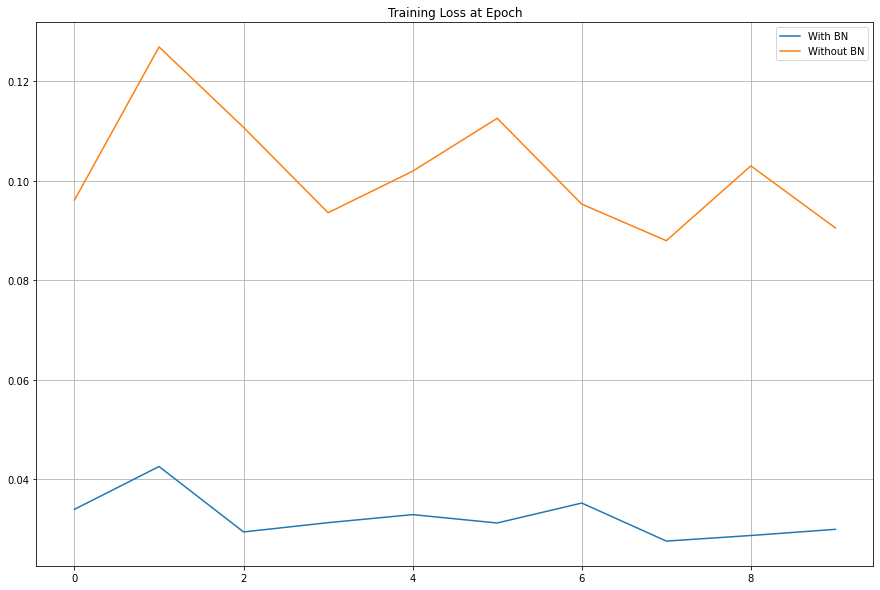

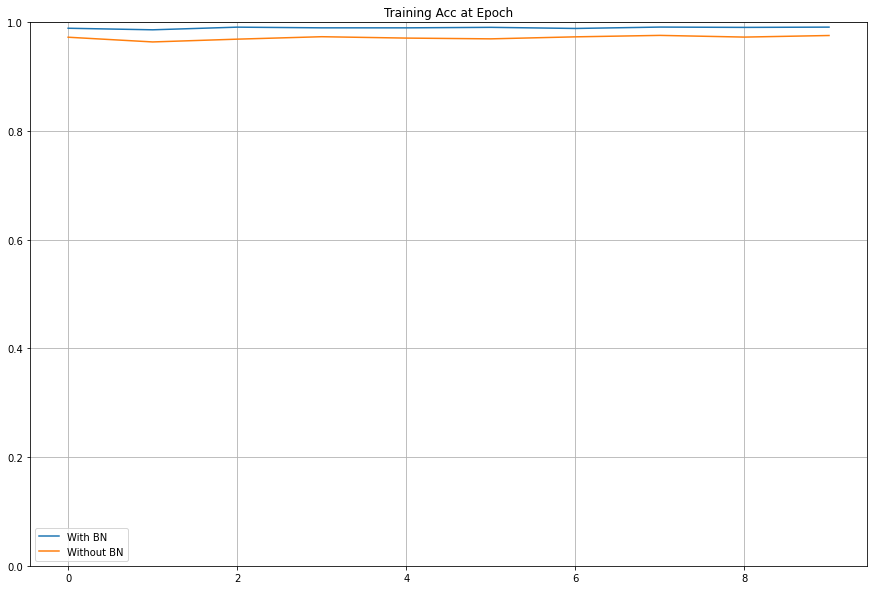

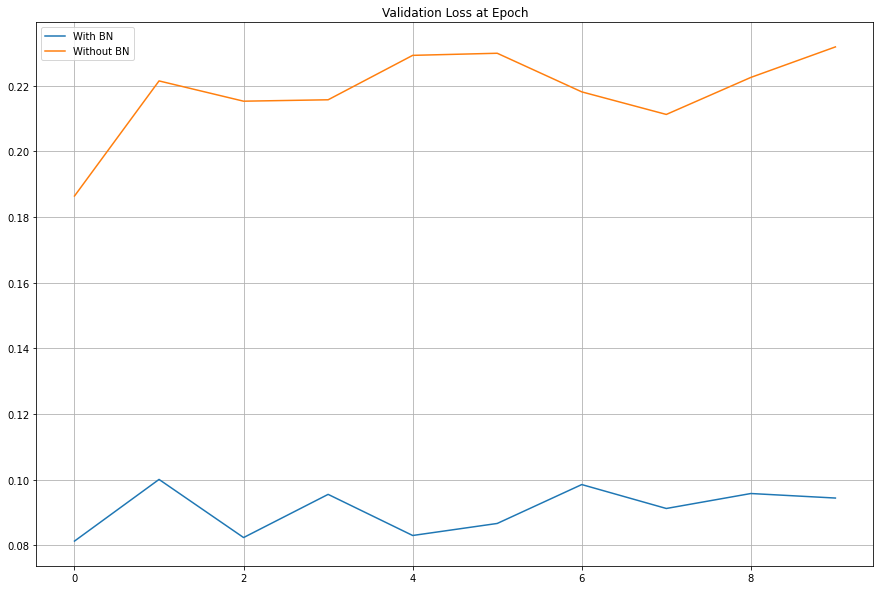

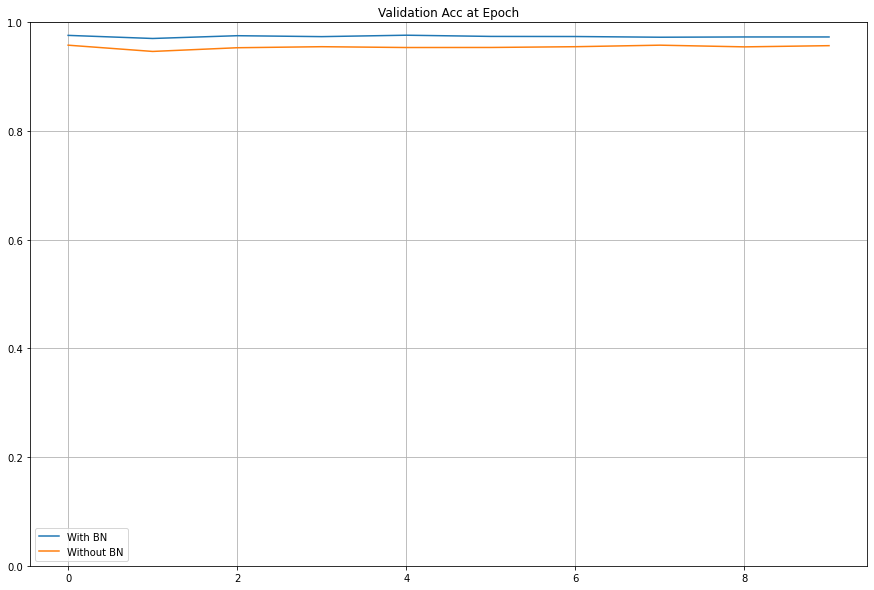

In [24]:
plot_compare(train_losses, title='Training Loss at Epoch')
plot_compare(train_accs, [0, 1.0], title='Training Acc at Epoch')
plot_compare(valid_losses, title='Validation Loss at Epoch')
plot_compare(valid_accs, [0, 1.0], title='Validation Acc at Epoch')